In [235]:
from vit_rollout import VITAttentionRollout
import torch
model = torch.hub.load('facebookresearch/deit:main', 
'deit_tiny_patch16_224', pretrained=True)
rollout = VITAttentionRollout(model, discard_ratio=0.9, head_fusion='max')
# mask = grad_rollout(input_tensor, category_index=243)

Using cache found in /home/yila22/.cache/torch/hub/facebookresearch_deit_main


In [249]:
# read image and convert to tensor
import torch
from torchvision import transforms
from PIL import Image
img = Image.open("both.png")
# convert_tensor = transforms.ToTensor()

normalize = transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    normalize,
])

img = transform(img).unsqueeze(0)


In [237]:
# plt.axis('off')
# plt.imshow(img[0].permute(1,2,0), )

In [239]:
mask = rollout(
    img
)

In [240]:
import seaborn as sns
%matplotlib inline
sns.set(font_scale=1.5)

In [241]:
mask = torch.tensor(mask)

In [242]:
# show the image
import matplotlib.pyplot as plt
# plt.imshow(img)
import pandas as pd
import cv2
import numpy as np

def show_cam_on_image(img, mask):
    heatmap = cv2.applyColorMap(np.uint8(255 * mask), cv2.COLORMAP_JET)
    heatmap = np.float32(heatmap) / 255
    cam = 0.7 * heatmap + 0.3 * np.float32(img)
    cam = cam / np.max(cam)
    return cam
# plt.imshow(img)
# plt.imshow(mask, alpha=0.8, cmap='rainbow')  #alpha设置透明度, cmap可以选择颜色
# plt.imshow()
# plt.imshow(mask, interpolation='nearest', cmap='seismic')
mask = mask.reshape(1, 1, 14, 14)
mask =  torch.nn.functional.interpolate(mask, scale_factor=16, mode='bilinear')
mask = mask.reshape(224, 224).cuda().data.cpu().numpy()
mask = (mask - mask.min()) / (mask.max() - mask.min())

In [246]:
# # mask.shape
# # mix the mask and the image

vis = show_cam_on_image(img[0].permute(1,2,0), mask)
# # vis =  np.uint8(255 * vis)
vis = cv2.cvtColor(np.array(vis), cv2.COLOR_RGB2BGR)
# plt.axis('off')


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


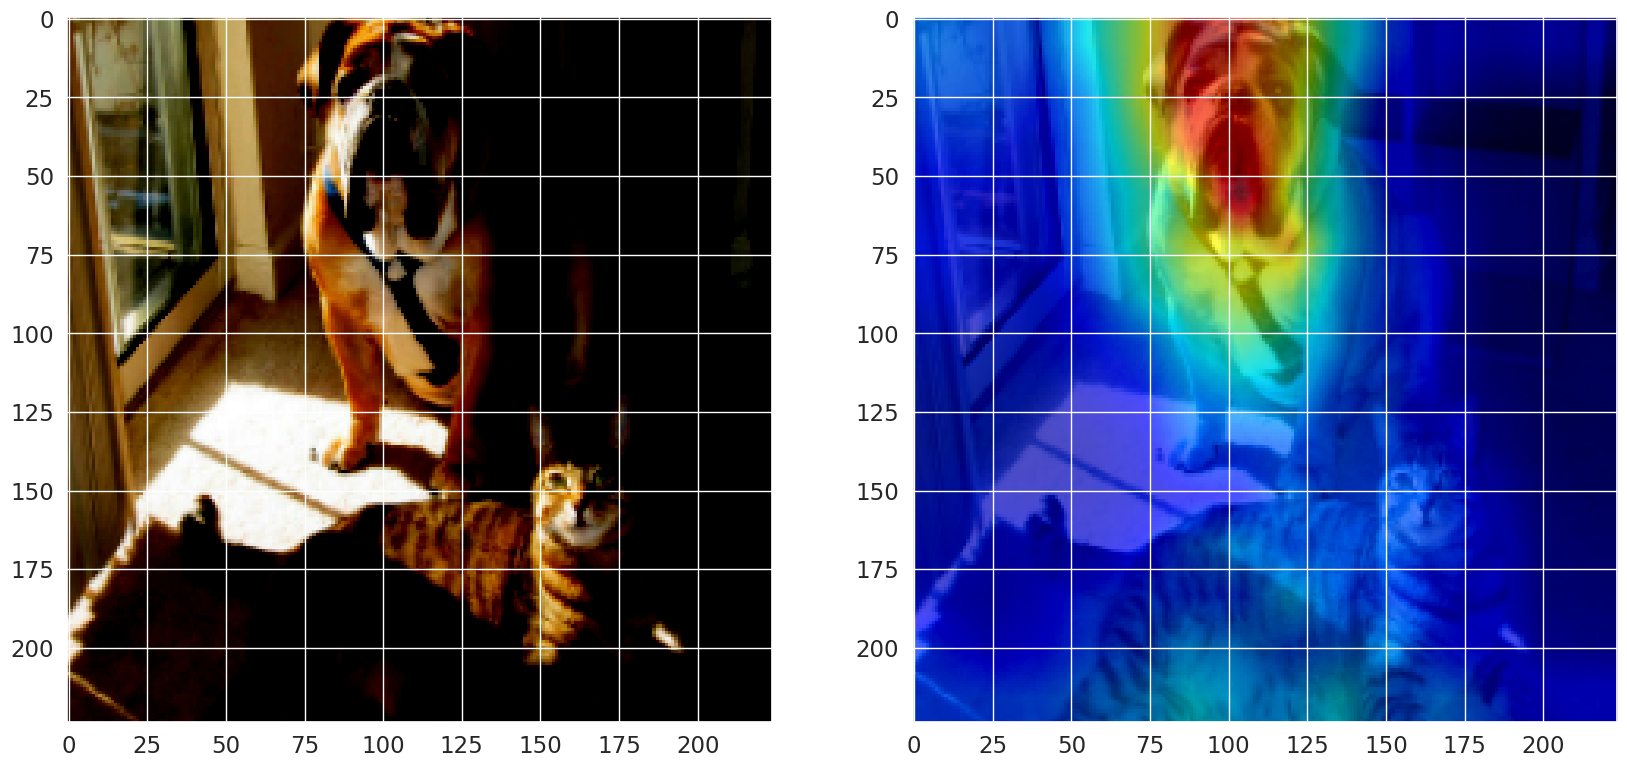

In [247]:
# plot two subplots
fig, ax = plt.subplots(1, 2, figsize=(20, 10))
# plt.axis('off')
ax[0].imshow(img[0].permute(1,2,0))
# plt.axis('off')
ax[1].imshow(vis)
# plt.imshow(img[0].permute(1,2,0))

In [173]:
# plt.axis('off')
# plt.imshow(mask, cmap='jet', alpha=0.5)
# plt.savefig('mask.png')

In [174]:
# plt.axis('off')
# plt.imshow(img[0].permute(1,2,0))
# plt.savefig('img.png')

In [160]:
# import matplotlib.pyplot as plt
 
# img_path = 'img.png'
# mask_path = 'mask.png'
 
# img = plt.imread(img_path)
# mask = plt.imread(mask_path)

# frame = plt.gca()
# # y 轴不可见
# frame.axes.get_yaxis().set_visible(False)
# # x 轴不可见
# frame.axes.get_xaxis().set_visible(False)

# plt.axis('off')
# #叠加显示img, mask
# plt.imshow(img, )

# plt.imshow(mask, alpha=0.7, cmap='jet')  #alpha设置透明度, cmap可以选择颜色
# plt.xticks([])
# plt.savefig('att.png', bbox_inches='tight', pad_inches=0)


In [161]:


# import cv2
# import numpy as np

# def norm_image(image):
#     """
#     Normalization image
#     :param image: [H,W,C]
#     :return:
#     """
#     image = image.copy()
#     image -= np.max(np.min(image), 0)
#     image /= np.max(image)
#     image *= 255.
#     return np.uint8(image)

# def visualize_heatmap(image, mask):
#     '''
#     Save the heatmap of ones
#     '''
#     masks = norm_image(mask).astype(np.uint8)
#     # mask->heatmap
#     heatmap = cv2.applyColorMap(masks, cv2.COLORMAP_JET)
#     heatmap = np.float32(heatmap)

#     heatmap = cv2.resize(heatmap, (image.shape[1], image.shape[0]))    # same shape

#     # merge heatmap to original image
#     cam = 0.4*heatmap + 0.6*np.float32(image)
#     return cam

In [108]:
# img_reshaped = img.reshape(224, 224,3).cpu().numpy()
# # img_reshaped = norm_image(img_reshaped)
# cam = visualize_heatmap(img_reshaped, mask)
# plt.imshow(cam)


In [248]:
!pip install foolbox

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 35.3 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 33.8/33.8 MB 81.2 MB/s eta 0:00:00a 0:00:01


In [266]:
labels = torch.LongTensor([0]*1000)
labels[282] = 1
labels = labels.reshape(1, 1000)
images = img

In [272]:
labels.shape

torch.Size([1, 1000])

In [271]:
with torch.no_grad():
    logits = model(images)
    print(logits.shape)

torch.Size([1, 1000])


In [268]:
import foolbox as fb
images = images.cuda()
fmodel = fb.PyTorchModel(model, bounds=(images.min(), images.max()))
attack = fb.attacks.LinfPGD()
epsilons = [0, 0.1]
_, advs, success = attack(fmodel, images, labels, epsilons=epsilons)

/home/yila22/anaconda3/envs/geomloss/lib/python3.8/site-packages/foolbox/models/pytorch.py:36: UserWarning: The PyTorch model is in training mode and therefore might not be deterministic. Call the eval() method to set it in evaluation mode if this is not intended.
  warnings.warn(


ValueError: labels must be 1D and must match the length of logits

In [273]:

import torchattacks
torch.backends.cudnn.deterministic = True
atk = torchattacks.PGD(model, eps=8/255, alpha=2/255, steps=4)
# If, images are normalized:
atk.set_normalization_used(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
adv_images = atk(images, labels)

RuntimeError: Expected floating point type for target with class probabilities, got Long

In [274]:
import torch
from denoising_diffusion_pytorch import Unet, GaussianDiffusion

model = Unet(
    dim = 64,
    dim_mults = (1, 2, 4, 8)
)

diffusion = GaussianDiffusion(
    model,
    image_size = 128,
    timesteps = 1000,   # number of steps
    loss_type = 'l1'    # L1 or L2
)

training_images = torch.randn(8, 3, 128, 128) # images are normalized from 0 to 1
loss = diffusion(training_images)
loss.backward()
# after a lot of training

sampled_images = diffusion.sample(batch_size = 4)
sampled_images.shape # (4, 3, 128, 128)

sampling loop time step: 100%|██████████| 1000/1000 [28:37<00:00,  1.72s/it]


torch.Size([4, 3, 128, 128])